In [3]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from math import *

In [80]:
def conditions(dataframe):
    if ((dataframe['grid'] == dataframe['grid']) & (dataframe['statusId'] in [3,4])):
        return 1
    else:
        return 0

def convert_time_to_milliseconds(time_str):
    # Handle NaN values
    if pd.isna(time_str):
        return np.nan
    try:
        # For 'mm:ss.s' format
        if ':' in time_str and 'days' not in time_str:
            td = pd.to_timedelta('00:' + time_str)
        # For '0 days 00:01:28.250000' format and potentially others
        else:
            td = pd.to_timedelta(time_str)
        return td.total_seconds() * 1000
    except:
        # In case of any unexpected format
        return np.nan

In [85]:
results = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\results.csv")
driverstandings = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\driver_standings.csv")
constructorstandings = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\constructor_standings.csv")
races = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\races.csv")
drivers = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\drivers.csv")
constructors = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\constructors.csv")
qualifying = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\qualifying.csv")

laps = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Projects\F1\Data\Fact\lap_times.csv")

In [86]:
# Merge dataframes
data = (results
        .merge(driverstandings, on=["raceId", "driverId"], how="left", suffixes=('', '_drop'))
        .merge(constructorstandings, on=["raceId", "constructorId"], how="left", suffixes=('', '_drop'))
        .merge(races, on="raceId", how="left", suffixes=('', '_drop'))
        .merge(driver, on="driverId", how="left", suffixes=('', '_drop'))
        .merge(constructors, on="constructorId", how="left", suffixes=('', '_drop'))
        .merge(qualifying, on=["raceId", "driverId"], how="left", suffixes=('', '_drop')))

data = data.loc[:, ~data.columns.str.endswith('_drop')]

# Change data formats
data = data.replace(r"\N", np.NaN)
data = data.replace(r"\\N", np.NaN)

for column in ['q1', 'q2', 'q3']:
    data[column] = data[column].apply(convert_time_to_milliseconds)

data = data.astype({'fastestLapSpeed': "Float64",
                    'position': 'Int64',
                    'milliseconds': 'Int64',
                    'fastestLap' : 'Int64',
                    'rank' : 'Int64',
                    'date' : 'datetime64[ns]',
                    'dob' : 'datetime64[ns]'
                    })

# Create new features
data["diff_grid_standing"] = abs(data["grid"] - data["position"])
data["fastestLapSpeedAvg"] = data.groupby('raceId').fastestLapSpeed.transform('mean')
data['Crashed'] = data.apply(conditions, axis=1)

## Data exploration
See for data retrieving:
- https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?resource=download
- Notebook: F1 data retriever

### Variables used to determine position
- Driver's standing
- Constructor's standing
- Driver's * Constructor's standing
- Grid position
- difference grid position, driver's standing
- Track dummy

### Interesting insights
- 1. the further away someone starts from their driverstanding, the higher the chance that they crash
- 2. the middle of the grid starters are more likely to crash
- 3. Some tracks have higher chance of crashing (why?)
- 4. There is some negative correlation between fastestlapspeed and the amount of crashes (correlation might be blurred by rainfall)
- 5. Drivers react differently to humidity but not to airtemperature
- 6. Constructors react differently to windspeed.

### Ideas/to-do
- See whether correlation number 1 is affected by the track (difficulty to overtake) 
- Check how rainfall affects race results
- Combine the rainfall correlation with chance that there is rainfall somewhere
- Check how temperature affects race results -> No
- Check how humidity affects race result -> only drivers performance
- Check how the two above affect drivers performance -> only humidity
- Check car failure and weather
- Use top speed to calculate car performance on the straight
- Combine top speed with lap speed to get an insight in corner speed.

### Ideas for good variables
- Ranking of the sector times in the qualification rounds (Q_laps)
- Ranking of speed in qualification rounds (Q_laps)
- add a variable that determines the amount of races that happened before in that year.
- Topspeed vs Tracktime (If high relative view corners and more straight otherwise not)
- Succesful overtakes per track


easonal Performance Index: A metric that averages a driver's or constructor's points per race in a season to gauge their overall performance trend.

Qualifying Advantage: The difference between a driver's qualifying position (average of q1, q2, q3) and their final race position, to assess the impact of qualifying on race performance.

Safety Car Benefit: Estimating the impact of safety car deployments on a driver's position improvement, assuming races with and without safety car periods can be distinguished.

Weather Adaptability: Creating a feature that reflects a driver's performance variance across different weather conditions, assuming weather data for races is available or can be integrated.

Teammate Comparison: The relative performance of a driver compared to their teammate, in terms of positions gained or lost, points, and fastest laps, to evaluate intra-team dynamics.

Circuit Specialty: Identifying circuits where a driver or constructor consistently performs better or worse than their average, indicating circuit specialization or difficulty.

Start Efficiency: A measure of how well drivers maintain or improve their position on the first lap compared to their starting grid position.

Consistency Score: Calculating the standard deviation of finish positions for each driver across a season or multiple seasons, with a lower score indicating higher consistency.

Pit Stop Strategy Effectiveness: Analysis of the number and timing of pit stops in relation to race performance, possibly requiring additional pit stop data.

Overtake Efficiency: Count of overtakes made by a driver during a race, normalized by the total number of laps, to gauge aggressiveness and overtaking skill.

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26320 entries, 0 to 26319
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   resultId                26320 non-null  int64         
 1   raceId                  26320 non-null  int64         
 2   driverId                26320 non-null  int64         
 3   constructorId           26320 non-null  int64         
 4   number                  26314 non-null  object        
 5   grid                    26320 non-null  int64         
 6   position                15413 non-null  Int64         
 7   positionText            26320 non-null  object        
 8   positionOrder           26320 non-null  int64         
 9   points                  26320 non-null  float64       
 10  laps                    26320 non-null  int64         
 11  time                    7414 non-null   object        
 12  milliseconds            7414 non-null   Int64 

In [8]:

data = data.astype({'fastestLapSpeed': "float64"})
data['Crashed'] = data.apply(conditions, axis=1)


print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24179 entries, 0 to 24178
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   resultId                24179 non-null  int64  
 1   raceId                  24179 non-null  int64  
 2   driverId                24179 non-null  int64  
 3   constructorId           24179 non-null  int64  
 4   number_x                24173 non-null  object 
 5   grid                    24179 non-null  int64  
 6   position_x              14559 non-null  object 
 7   positionText_x          24179 non-null  object 
 8   positionOrder           24179 non-null  int64  
 9   points_x                24179 non-null  float64
 10  laps                    24179 non-null  int64  
 11  time_x                  7129 non-null   object 
 12  milliseconds            7129 non-null   object 
 13  fastestLap              7796 non-null   object 
 14  rank                    8019 non-null 

C:\Users\jornv\AppData\Local\Temp\ipykernel_7260\301777692.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


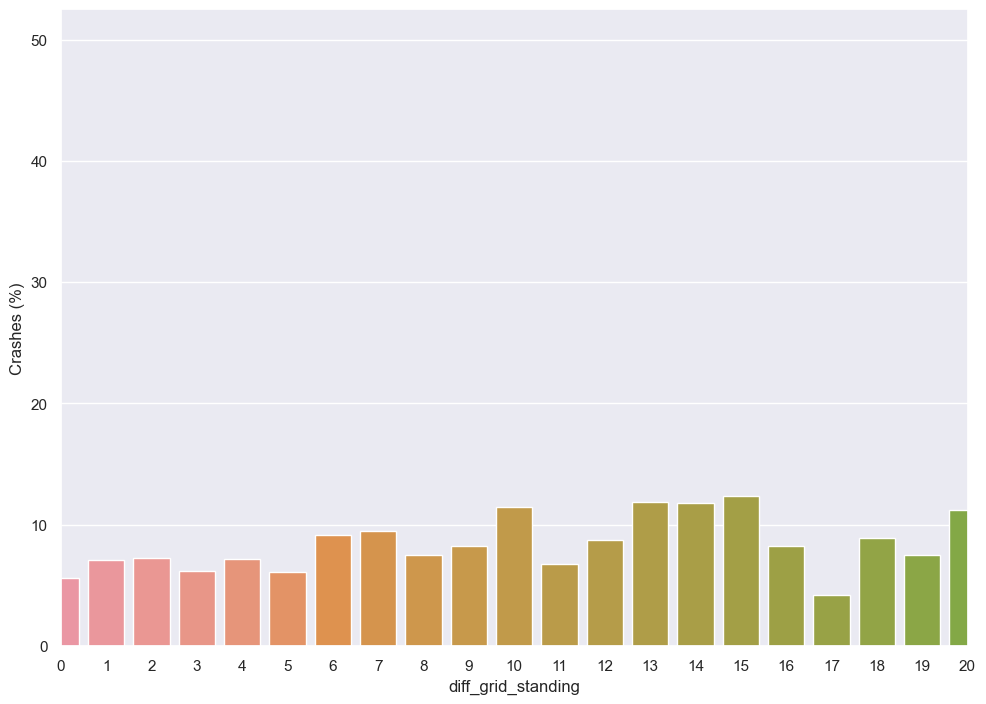

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(
    data=data,
    x="diff_grid_standing",
    y="Crashed",
    ci=None,
    estimator=lambda x: sum(x==1)*100.0/len(x)
)

plot.set(xlabel='diff_grid_standing', ylabel='Crashes (%)')
plot.set_xlim(0, 20)
plt.show()


C:\Users\jornv\AppData\Local\Temp\ipykernel_7260\2022273824.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


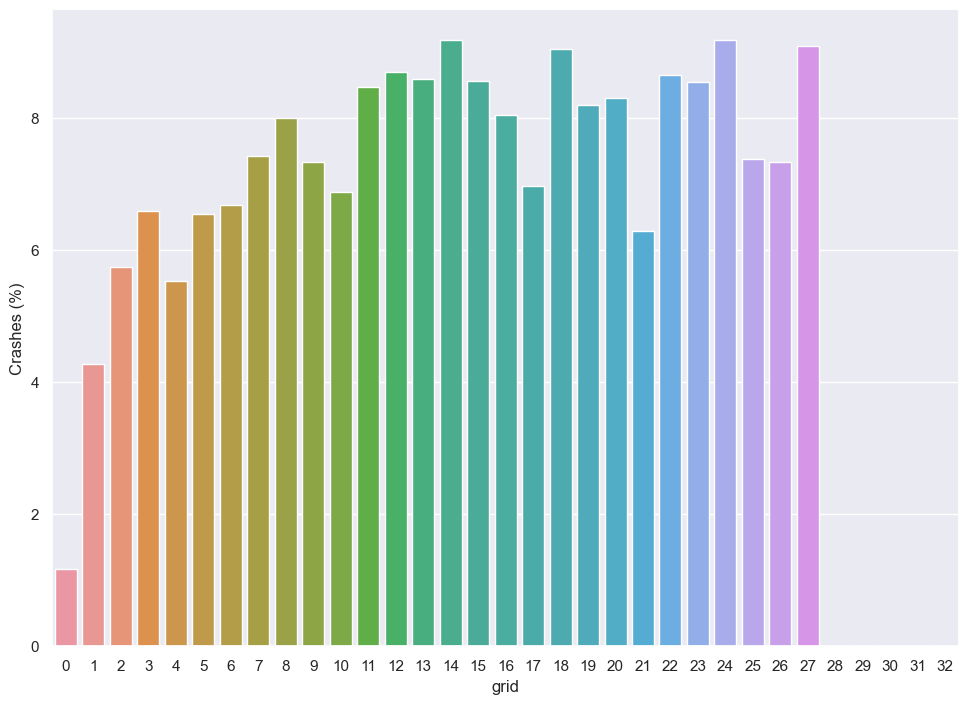

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(
    data=data,
    x="grid",
    y="Crashed",
    ci=None,
    estimator=lambda x: sum(x==1)*100.0/len(x)
)

plot.set(xlabel='grid', ylabel='Crashes (%)')
plt.show()

C:\Users\jornv\AppData\Local\Temp\ipykernel_7260\2287809605.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


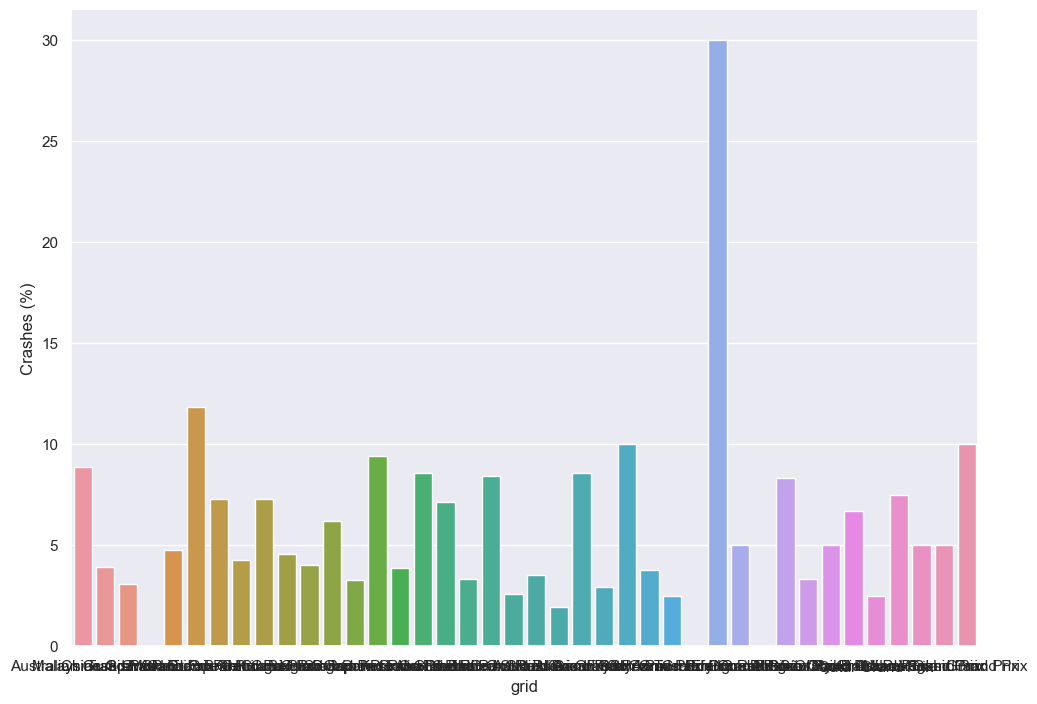

C:\Users\jornv\AppData\Local\Temp\ipykernel_7260\2287809605.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


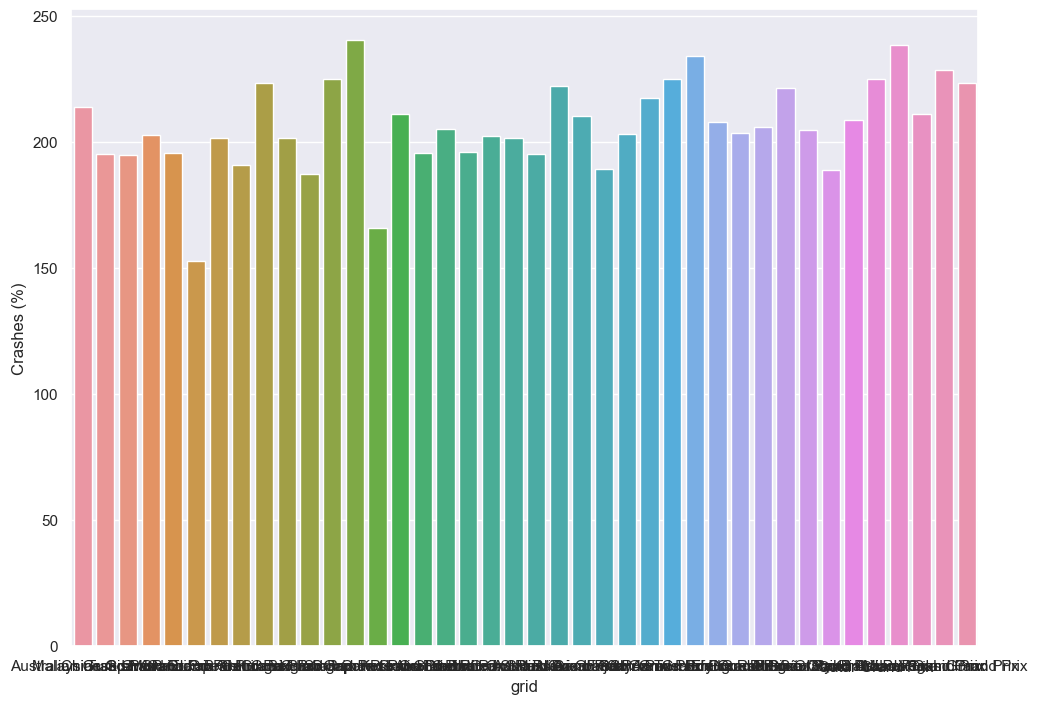

In [11]:
#data_temp = data
#data_temp = data_temp.groupby('name').fastestLapSpeedAvg.transform('mean')/data_temp.groupby('name').Crashed.transform('mean')

sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(
    data=data[data["year"] >= 2011],
    x="name",
    y="Crashed",
    ci=None,
    estimator=lambda x: sum(x==1)*100.0/len(x)
)

plot.set(xlabel='grid', ylabel='Crashes (%)')
plt.show()

plot = sns.barplot(
    data=data[data["year"] >= 2011],
    x="name",
    y="fastestLapSpeedAvg",
    ci=None
)

plot.set(xlabel='grid', ylabel='Crashes (%)')
plt.show()

C:\Users\jornv\anaconda3\envs\f1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jornv\anaconda3\envs\f1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jornv\anaconda3\envs\f1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jornv\anaconda3\envs\f1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

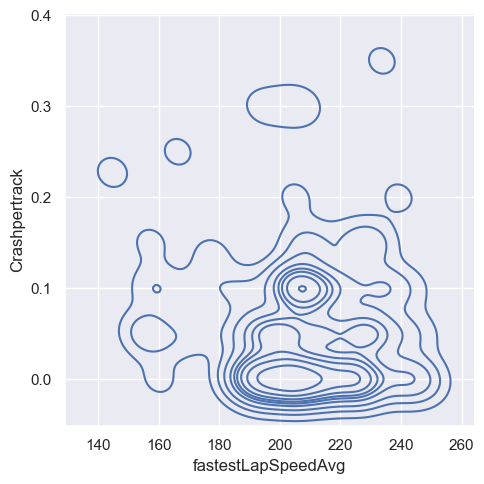

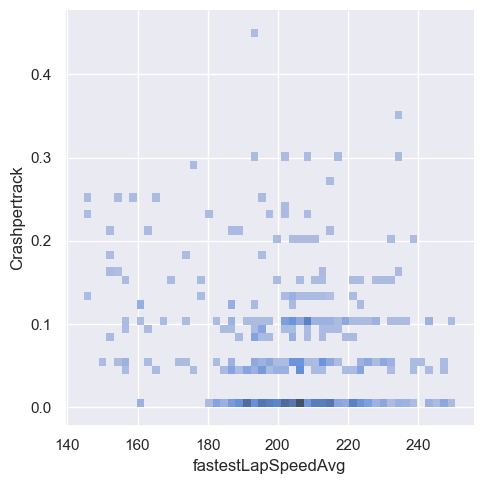

In [12]:
data["Crashpertrack"] = data.groupby('raceId').Crashed.transform('mean')

sns.displot(data=data[data["year"] >= 2016],x="fastestLapSpeedAvg",y="Crashpertrack",kind="kde")

plot.set(xlabel='grid', ylabel='Crashes (%)')

sns.displot(data=data,x="fastestLapSpeedAvg",y="Crashpertrack")

plt.show()

In [13]:
Qraces["QHigh_speed"] = Qraces[Qraces["IsAccurate"] == True].groupby(['DriverNumber', "Race", "Year"]).SpeedST.transform('mean')
print(Qraces)

KeyError: 'IsAccurate'

# Check how weather affects a driver's performance

In [24]:
R_weather_group = R_weather.groupby(["Race", "Year"]).mean().reset_index()

R_weather_group["name"] = R_weather_group["Race"] + " Grand Prix"
R_weather_group['year'] = R_weather_group['Year']
R_weather_group.drop(columns = ["Year", "Race", "Unnamed: 0"])

,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,name,year
0,25.656186,56.465464,1001.984021,0.000000,42.652577,52.113402,2.785567,70th Anniversary Grand Prix,2020
1,24.726891,58.477311,1018.023950,0.000000,28.706303,291.857143,0.381092,Abu Dhabi Grand Prix,2021
2,28.635526,64.254386,1013.902632,0.000000,34.192544,270.710526,2.296930,Abu Dhabi Grand Prix,2022
3,30.322326,45.893023,1014.324186,0.027907,32.758140,207.311628,2.000000,Abu Dhabi Grand Prix,2018
4,25.991509,64.377830,1015.824528,0.000000,29.868396,230.933962,1.365566,Abu Dhabi Grand Prix,2019
...,...,...,...,...,...,...,...,...,...
97,29.924111,40.092095,991.874704,0.000000,43.725296,104.063241,2.475494,Tuscan Grand Prix,2020
98,28.632500,59.243333,992.012083,0.004167,37.212083,107.104167,0.934167,United States Grand Prix,2021
99,31.474380,52.421488,1009.052066,0.037190,45.592975,168.673554,2.080165,United States Grand Prix,2022
100,20.979048,51.362857,1004.730476,0.000000,27.133810,187.985714,1.950476,United States Grand Prix,2018


In [25]:
data = data.merge(R_weather_group, on = ["name", "year"])

[2021 2022]


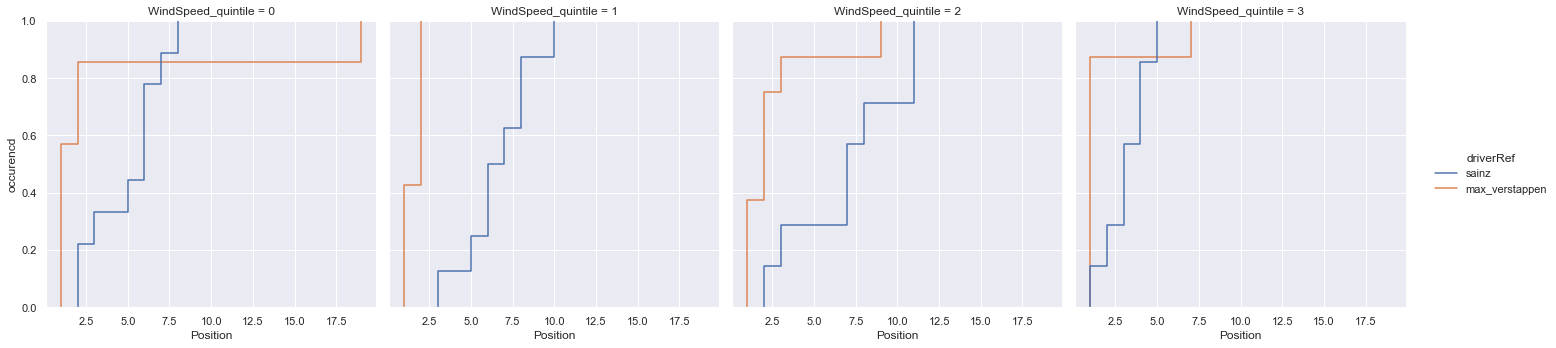

In [37]:
data_drive = data[data["driverRef"].isin(["sainz", "max_verstappen"])]
data = data.dropna(subset=['position_x'])
data["position_x"] = data["position_x"].astype(int)
data['Airtemp_quintile'] = pd.qcut(data['AirTemp'], 4, labels=False)
data['Humidity_quintile'] = pd.qcut(data['Humidity'], 4, labels=False)
data['WindSpeed_quintile'] = pd.qcut(data['WindSpeed'], 4, labels=False)

plot = sns.displot(
    data_drive,
    x="position_x",
    hue = "driverRef",
    col = "WindSpeed_quintile",
    kind = "ecdf"
)

plot.set(xlabel='Position', ylabel='occurencd')
plt.show()

# Weather effect on constructors

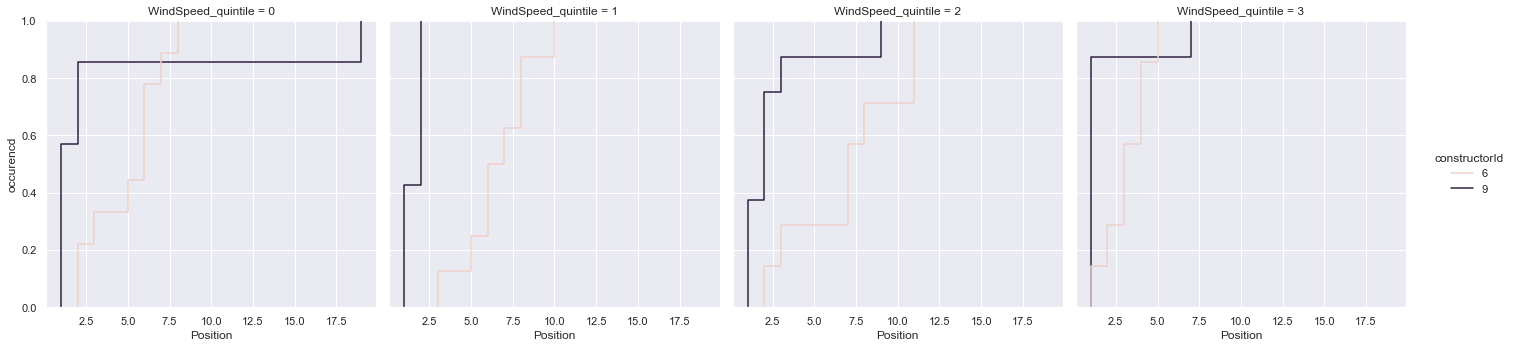

In [33]:
data_const = data[data["constructorId"].isin([6,9])]

plot = sns.displot(
    data_drive,
    x="position_x",
    hue = "constructorId",
    col = "WindSpeed_quintile",
    kind = "ecdf"
)

plot.set(xlabel='Position', ylabel='occurencd')
plt.show()

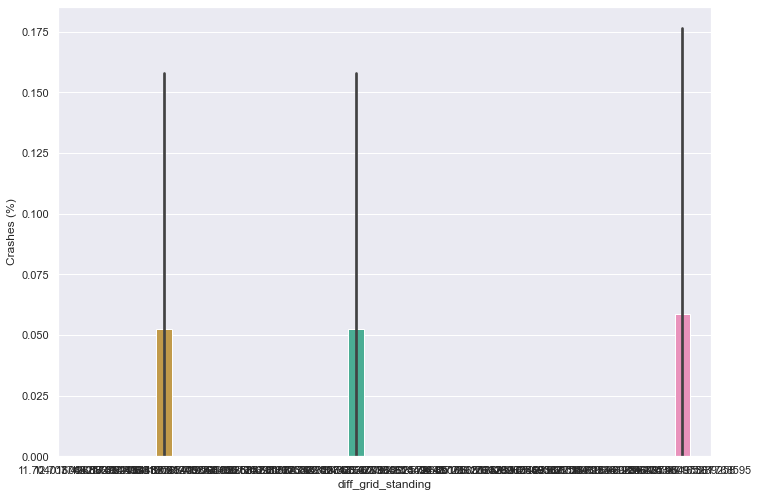

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(
    data=data,
    x="AirTemp",
    y="Crashed"
)

plot.set(xlabel='diff_grid_standing', ylabel='Crashes (%)')
plt.show()

In [85]:
mean_year_list = []
mean_driver_list = []
for index, row in data.iterrows():
    raceId = row[1]
    year = row[18]
    driver = row[2]
    mean_year = data[(data["raceId"] <= raceId) & (data["year"] == year)]["fastestLapSpeed"].mean()
    mean_driver = data[(data["raceId"] <= raceId) & (data["year"] == year) & (data["driverId"] == driver)]["fastestLapSpeed"].mean()
    mean_year_list.append(mean_year)
    mean_driver_list.append(mean_driver)

data["fastestLapSpeedAvg_drive"] = mean_driver_list
data["fastestLapSpeedAvg_year"] = mean_year_list
data["fastestLapSpeedAvg_diff"] = data["fastestLapSpeedAvg_drive"] - data["fastestLapSpeedAvg_year"]

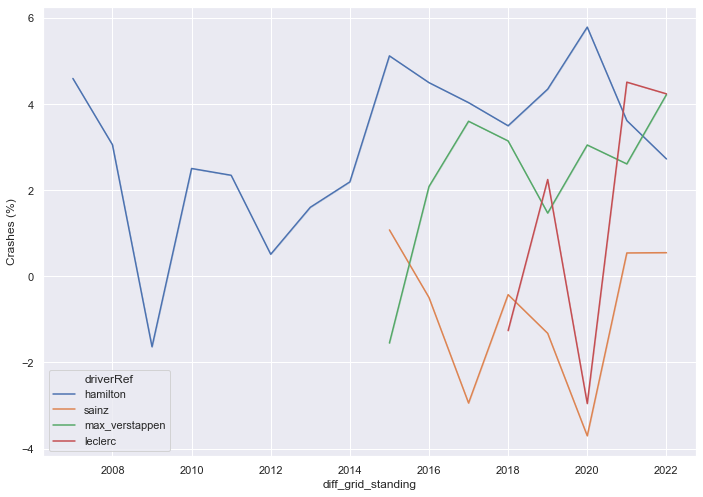

[2008 2007 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995
 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981
 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969 1968 1967
 1966 1965 1964 1963 1962 1961 1960 1959 1958]


In [49]:
data_drive = data[data["driverRef"].isin(["sainz", "max_verstappen", "hamilton", "leclerc"])]
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.lineplot(
    data=data_drive,
    x="year",
    y="fastestLapSpeedAvg_diff",
    hue="driverRef"
)

plot.set(xlabel='diff_grid_standing', ylabel='Crashes (%)')
plt.show()

print(data["year"].unique())

In [52]:
Q_laps = pd.read_csv(r"C:\Users\jornv\OneDrive\Documenten\Python data\Q_laps.csv")

C:\Users\jornv\Programs\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
# Merge dataframes
data = (results
        .merge(driverstandings, on=["raceId", "driverId"], how="left")
        .merge(constructorstandings, on=["raceId", "constructorId"], how="left")
        .merge(races, on="raceId", how="left")
        .merge(driver, on="driverId", how="left")
        .merge(constructors, on="constructorId", how="left"))

In [47]:
# Columns to be shifted
columns_to_shift = ["grid", "position"]

# Group the data
data_gr = data.groupby(['year', 'driverId'])[columns_to_shift]

# Shift the columns
data_shifted = data_gr.shift(periods=-1)

# Add "_t1" suffix to column names
data_shifted.columns = [f"{col}_t1" for col in data_shifted.columns]

# Join the shifted columns to the original dataframe
data = data.join(data_shifted)

In [40]:
results = results.merge(laps.groupby(['raceId', 'driverId'])['milliseconds'].agg(['mean', 'std']).reset_index(), on = ['raceId', 'driverId'], how = 'left')

In [52]:
data_selected = data[data['raceId'] >= 1000]

C:\Users\jornv\AppData\Local\Temp\ipykernel_7260\3191644030.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


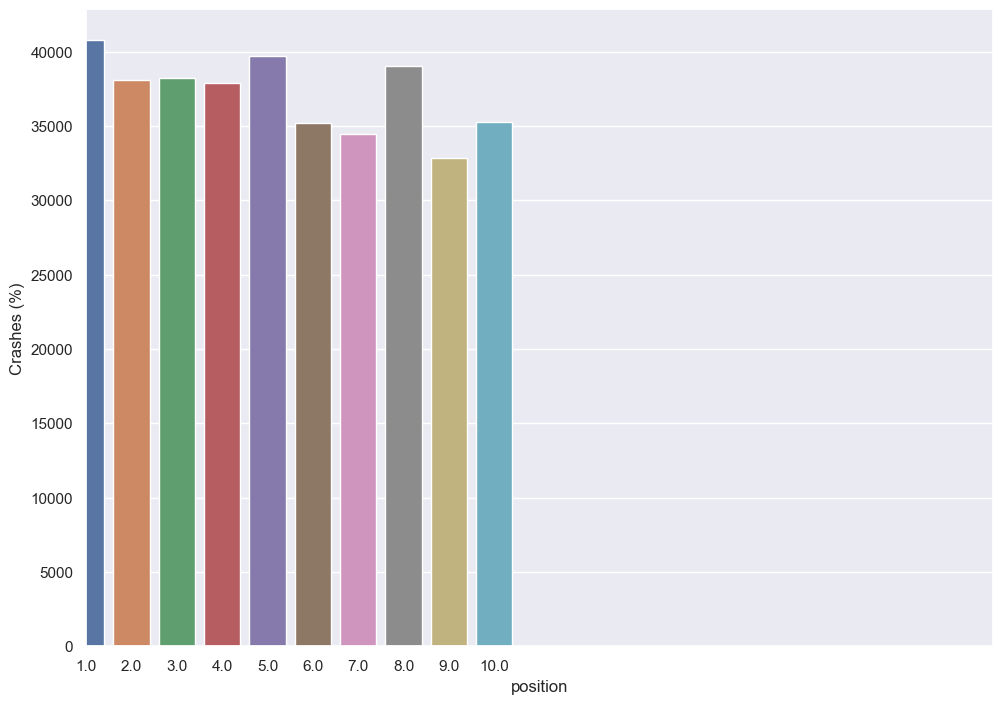

In [53]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(
    data=data_selected,
    x="position_t1",
    y="std",
    ci=None,
)

plot.set(xlabel='position', ylabel='Crashes (%)')
plot.set_xlim(0, 20)
plt.show()


In [30]:
results_selected[['position', 'std']].groupby(['position']).mean().reset_index()

,position,std
0,1,50242.865844
1,10,49103.069720
2,11,48467.206282
3,12,48791.863398
4,13,44014.005145
5,14,44334.219667
6,15,36128.946580
7,16,39161.097152
8,17,39964.632446
9,18,9051.169346
